In [1]:
# Installing required libraries
!pip install -q imbalanced-learn xgboost shap


In [2]:
# Import semua library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import joblib
import shap

RANDOM_SEED = 42
sns.set_style("whitegrid")


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA


In [4]:
# Load dataset dari drive
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data-bank.csv")


In [5]:
# Menampilkan ukuran data, tipe data, dan missing value
data.info()
print("Dataset shape:", data.shape)

missing_pct = data.isna().mean() * 100
print("Missing values (percent):")
print(missing_pct.sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

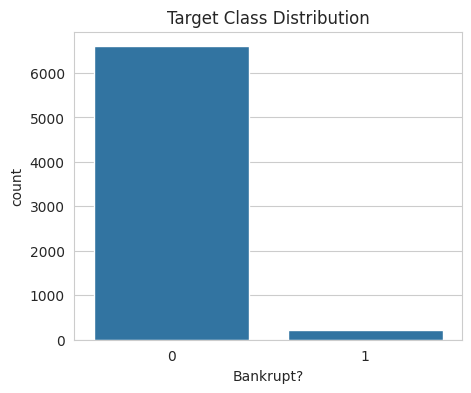

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64


In [6]:
# Visualisasi distribusi target
target_col = "Bankrupt?"
if data[target_col].dtype == 'O':
    y = data[target_col].str.lower().replace({'yes':1,'y':1,'no':0,'n':0}).astype(int)
else:
    y = data[target_col].astype(int)

plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()

print(y.value_counts(normalize=True))


In [7]:
# Cek total missing values per kolom
print("Missing Values per Kolom:")
print(data.isnull().sum())

# Cek total missing values di seluruh dataset
total_missing = data.isnull().sum().sum()
print(f"\nTotal Missing Values: {total_missing}")

Missing Values per Kolom:
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

Total Missing Values: 0


In [9]:
# Hitung korelasi numerik
corr_matrix = pd.concat([data[num_cols], y], axis=1).corr()

# Ambil kolom korelasi terhadap target
if isinstance(corr_matrix[target_col], pd.Series):
    corrs = corr_matrix[target_col].drop(target_col)
else:
    corrs = corr_matrix[target_col].iloc[:,0].drop(target_col)

# Urutkan dari terbesar
corrs = corrs.abs().sort_values(ascending=False)

print("Top 10 strongest correlations:")
display(corrs.head(10))


Top 10 strongest correlations:


,Bankrupt?
Net Income to Total Assets,0.315457
ROA(A) before interest and % after tax,0.282941
ROA(B) before interest and depreciation after tax,0.273051
ROA(C) before interest and depreciation before interest,0.260807
Net worth/Assets,0.250161
Debt ratio %,0.250161
Persistent EPS in the Last Four Seasons,0.219560
Retained Earnings to Total Assets,0.217779
Net profit before tax/Paid-in capital,0.207857
Per Share Net profit before tax (Yuan ¥),0.201395


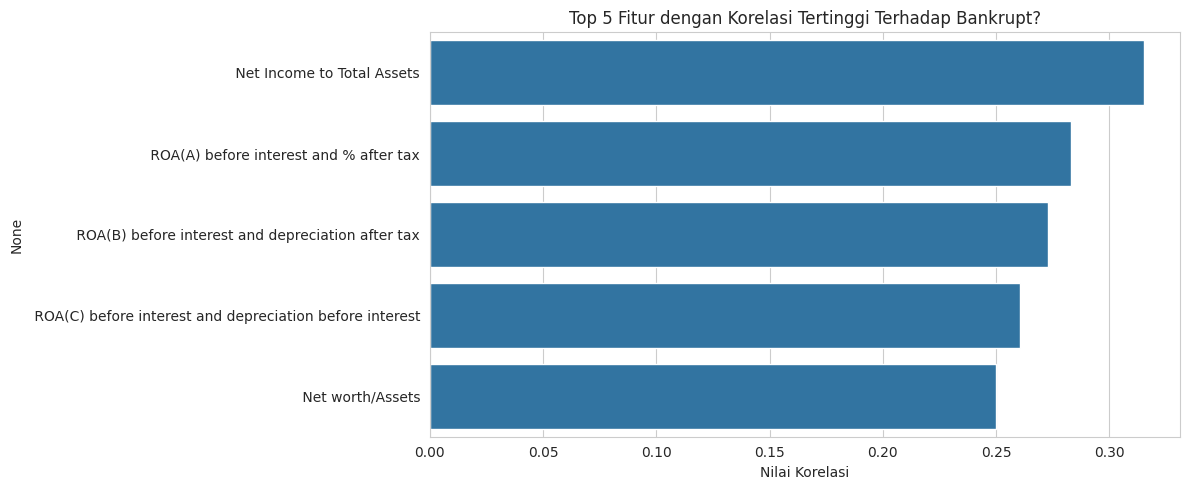

In [24]:
plt.figure(figsize=(12, 5))
top_features = corrs.head(5)
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 5 Fitur dengan Korelasi Tertinggi Terhadap Bankrupt?')
plt.xlabel('Nilai Korelasi')
plt.tight_layout()
plt.show()


## Data Preparation

In [10]:
# Menghapus duplikat
data = data.drop_duplicates()

# Membersihkan kolom numeric yang berbentuk string
for col in data.select_dtypes(include='object').columns:
    try:
        data[col] = data[col].str.replace(",", "").str.replace("%", "")
    except:
        pass

# Hapus kolom yang memiliki missing value lebih dari 50%
missing_pct = data.isna().mean() * 100
drop_cols = missing_pct[missing_pct > 50].index.tolist()
data = data.drop(columns=drop_cols)


In [11]:
# Menentukan X dan y setelah data dibersihkan
y = data[target_col].astype(int)
X = data.drop(columns=[target_col])


In [12]:
# Memisahkan data dengan stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)


In [13]:
# Menentukan kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

# Pipeline numerik
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline kategorik (jika ada)
if len(categorical_features) > 0:
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])
    transformers = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
else:
    transformers = [
        ("num", numeric_transformer, numeric_features)
    ]

# Gabung dengan ColumnTransformer
preprocessor = ColumnTransformer(transformers)

# Fit transform data
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


In [14]:
# Menangani ketidakseimbangan data menggunakan SMOTE
sm = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Bankrupt?
0    5279
1     176
Name: count, dtype: int64
After SMOTE: Bankrupt?
0    5279
1    5279
Name: count, dtype: int64


## Modeling

### Base Model Training & CV

In [15]:
# Menyiapkan 5 model baseline
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 5-fold cross validation menggunakan F1-score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

base_cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_res, y_train_res, cv=skf, scoring='f1')
    base_cv_scores[name] = scores.mean()

print("Base Model CV F1 Scores:")
display(base_cv_scores)


Base Model CV F1 Scores:


{'LogisticRegression': np.float64(0.9014907917867641),
 'DecisionTree': np.float64(0.9282675791774022),
 'RandomForest': np.float64(0.9605246958889166),
 'XGBoost': np.float64(0.9866261746124229),
 'KNN': np.float64(0.942940818811181)}

### Manual Model Tuning

In [16]:
# Parameter grid untuk tuning manual
param_grids = {
    "LogisticRegression": {"C":[0.01,0.1,1,10]},
    "DecisionTree": {"max_depth":[4,6,8,12]},
    "RandomForest": {"n_estimators":[100,200],"max_depth":[6,8,12]},
    "XGBoost": {"n_estimators":[100,200],"max_depth":[3,6,8]},
    "KNN": {"n_neighbors":[3,5,7,9]}
}

# Simpan best model
best_estimators = {}

for name in models.keys():
    print(f"Training GridSearch for: {name}")
    grid = GridSearchCV(models[name], param_grids[name], cv=skf, scoring='f1')
    grid.fit(X_train_res, y_train_res)
    best_estimators[name] = grid.best_estimator_
    print("Best params:", grid.best_params_)


Training GridSearch for: LogisticRegression
Best params: {'C': 10}
Training GridSearch for: DecisionTree
Best params: {'max_depth': 12}
Training GridSearch for: RandomForest
Best params: {'max_depth': 12, 'n_estimators': 100}
Training GridSearch for: XGBoost
Best params: {'max_depth': 6, 'n_estimators': 200}
Training GridSearch for: KNN
Best params: {'n_neighbors': 3}


# Evaluate

In [17]:
# Fungsi untuk menilai performa model
def evaluate(model, Xtest, ytest):
    prob = model.predict_proba(Xtest)[:,1]
    ypred = (prob >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(ytest, ypred),
        "precision": precision_score(ytest, ypred),
        "recall": recall_score(ytest, ypred),
        "f1": f1_score(ytest, ypred),
        "roc_auc": roc_auc_score(ytest, prob),
        "y_pred": ypred,
        "y_prob": prob
    }


In [18]:
# Menilai semua model yang sudah dituning
tuned_metrics = {}

for name, model in best_estimators.items():
    tuned_metrics[name] = evaluate(model, X_test_prep, y_test)

# Menampilkan hasil dalam tabel
pd.DataFrame({k:{m:v for m,v in tuned_metrics[k].items() if m!="y_pred" and m!="y_prob"} for k in tuned_metrics}).T


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.881965,0.176796,0.727273,0.284444,0.858402
DecisionTree,0.933284,0.252632,0.545455,0.345324,0.741925
RandomForest,0.953079,0.375000,0.681818,0.483871,0.932877
XGBoost,0.964809,0.458333,0.500000,0.478261,0.940341
KNN,0.906891,0.192593,0.590909,0.290503,0.794895


Best Model: RandomForest


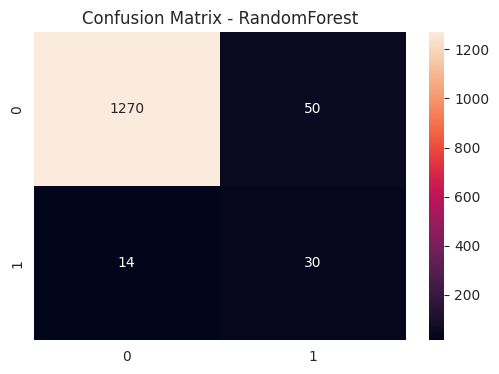

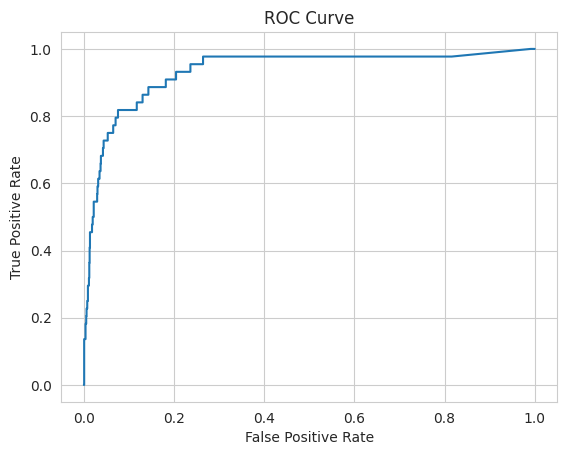

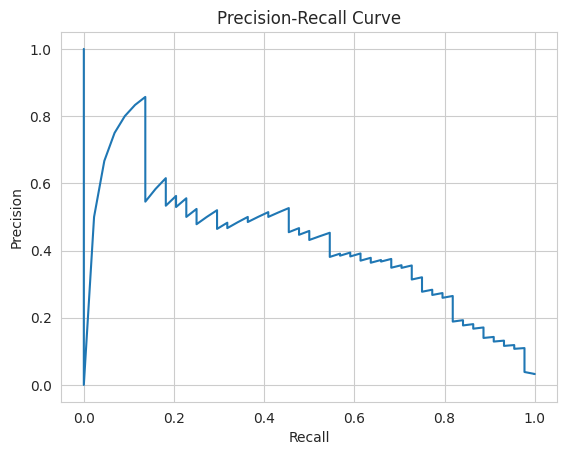

In [19]:
# Mencari best model berdasarkan F1 Score
best_name = max(tuned_metrics.items(), key=lambda x: x[1]['f1'])[0]
best_model = best_estimators[best_name]
print("Best Model:", best_name)

res = tuned_metrics[best_name]

# Confusion Matrix
cm = confusion_matrix(y_test, res["y_pred"])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision Recall Curve
prec, rec, _ = precision_recall_curve(y_test, res["y_prob"])
plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


# FEATURE IMPORTANCE

In [20]:
# Menghitung feature importance menggunakan permutation importance
perm = permutation_importance(
    best_model,
    X_test_prep,
    y_test,
    n_repeats=10,
    random_state=RANDOM_SEED
)

# Mendapatkan nama kolom setelah preprocessing
try:
    cat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
except:
    cat_names = []

feature_names = list(numeric_features) + list(cat_names)
importance = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("Top 10 Feature Importance:")
display(importance.head(10))


Top 10 Feature Importance:


,0
Cash Turnover Rate,0.004545
Net profit before tax/Paid-in capital,0.002493
Net Income to Total Assets,0.002419
Interest Expense Ratio,0.002346
Net Income to Stockholder's Equity,0.002126
Per Share Net profit before tax (Yuan ¥),0.001979
Pre-tax net Interest Rate,0.001906
Interest Coverage Ratio (Interest expense to EBIT),0.001760
Operating profit per person,0.001760
Quick Asset Turnover Rate,0.001686
